# Анализ бизнес показателей для Procrastinate Pro+

Исследование с точки зрения маркетингового аналитика для развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.  

Предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов,
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

### Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
sns.color_palette('tab20'); # задаем цветовую палитру, чтобы цвета на графиках не повторялись

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
#переименуем столбцы на змеиным регистром
visits.columns = ['user_id','region','device','channel','session_start','session_end']
orders.columns = ['user_id','event_dt','revenue']
costs.columns = ['dt','channel','costs']

In [4]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [5]:
print(visits.head())
print(orders.head())
print(costs.head())

        user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40  
        user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99
           dt   channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.

In [6]:
print(visits.isna().sum())
print()
print(orders.isna().sum())
print()
print(costs.isna().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64


In [7]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


Пропусков в данных не обнаружено. Полных дубликатов тоже не обнаружено.

In [8]:
visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942

Типы данных соответствуют содержимому.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Функция для создания пользовательских профилей

In [9]:
def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для расчёта удержания

In [10]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчёта конверсии

In [11]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчёта LTV и ROI

In [12]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция для сглаживания фрейма

In [13]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### Функция для визуализации удержания

In [14]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция для визуализации конверсии

In [15]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция для визуализации LTV и ROI

In [16]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построем таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [17]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [18]:
print('Минимальная дата привлечения покупателей:', profiles['dt'].min())
print('Максимальная дата привлечения покупателей:', profiles['dt'].max())

Минимальная дата привлечения покупателей: 2019-05-01
Максимальная дата привлечения покупателей: 2019-10-27


Даты с 1 мая по 27 октября 2019 года соответствуют описанию проекта

In [19]:
payers = profiles.groupby('region').agg({'user_id': 'count','payer':'sum'}).rename(columns={'user_id': 'cohort_size'})
payers['percentage_of_payers']=payers['payer']/payers['cohort_size']*100
payers.drop(['payer'],axis=1).sort_values('percentage_of_payers', ascending=False)

,cohort_size,percentage_of_payers
region,,
United States,100002,6.901862
Germany,14981,4.111875
UK,17575,3.982930
France,17450,3.799427


Выше всего доля платящих пользователей в США

In [20]:
payers = profiles.groupby('device').agg({'user_id': 'count','payer':'sum'}).rename(columns={'user_id': 'cohort_size'})
payers['percentage_of_payers']=payers['payer']/payers['cohort_size']*100
payers.drop(['payer'],axis=1).sort_values('percentage_of_payers', ascending=False)

,cohort_size,percentage_of_payers
device,,
Mac,30042,6.364423
iPhone,54479,6.207897
Android,35032,5.851793
PC,30455,5.046790


Выше всего доля платящих на устройствах Mac. Доли платящих с разных устройств различаются меньше чем доли платящих в разных странах

In [21]:
payers = profiles.groupby('channel').agg({'user_id': 'count','payer':'sum'}).rename(columns={'user_id': 'cohort_size'})
payers['percentage_of_payers']=payers['payer']/payers['cohort_size']*100
payers.drop(['payer'],axis=1).sort_values('percentage_of_payers', ascending=False)

,cohort_size,percentage_of_payers
channel,,
FaceBoom,29144,12.204914
AdNonSense,3880,11.340206
lambdaMediaAds,2149,10.469986
TipTop,19561,9.600736
RocketSuperAds,4448,7.913669
WahooNetBanner,8553,5.296387
YRabbit,4312,3.826531
MediaTornado,4364,3.574702
LeapBob,8553,3.063253


Больше всего доля плательщиков из источника FaceBoom, затем AdNonSense и lambdaMediaAds	

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 

In [22]:
print('Суммарные расходы на рекламу:')
round(costs['costs'].sum(),2)

Суммарные расходы на рекламу:


105497.3

In [23]:
ads = costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs', ascending=False)
ads['percentage']=ads['costs']/(ads['costs'].sum())*100
ads

,costs,percentage
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


Больше всего потрачено на привлечение пользователей через канал "TipTop", а меньше всего на "YRabbit"

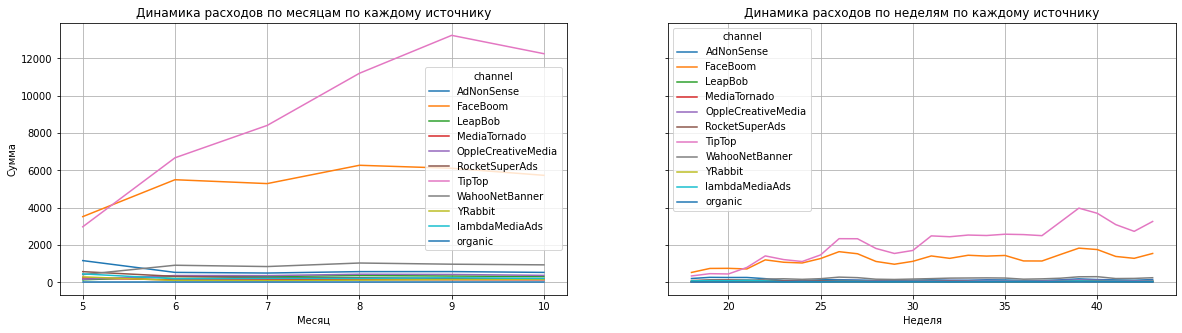

In [24]:
profiles['week']=profiles['first_ts'].dt.isocalendar().week #создаем столбец с номером недели
profiles['nmonth']=pd.DatetimeIndex(profiles['first_ts']).month

plt.figure(figsize=(20,5))
ax1 = plt.subplot(1, 2, 1)
profiles.pivot_table(index='channel', columns='nmonth',values='acquisition_cost', aggfunc='sum').T.plot(
    grid=True,
    ax=ax1)
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.title('Динамика расходов по месяцам по каждому источнику')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
profiles.pivot_table(index='channel', columns='week',values='acquisition_cost', aggfunc='sum').T.plot(
    grid=True,
    ax=ax2,
    legend=True)
plt.xlabel('Неделя')
plt.title('Динамика расходов по неделям по каждому источнику');

Расходы на рекламу в TipTop и FaceBoom растут

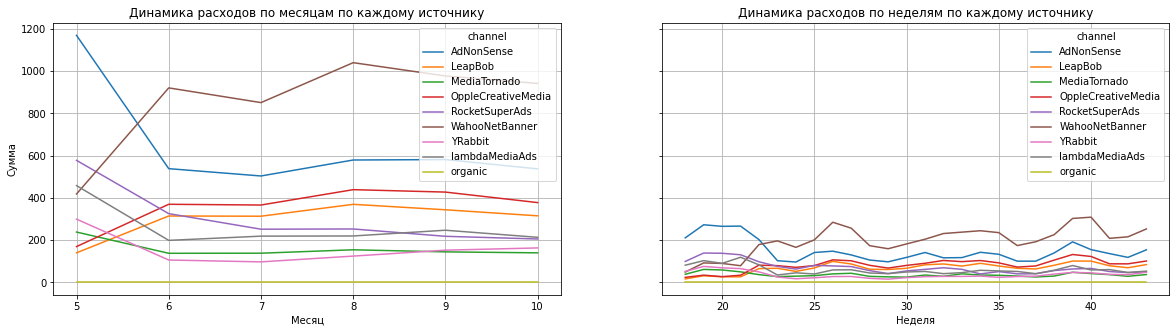

In [25]:
profiles_wo_top = profiles.query('channel != "FaceBoom" & channel != "TipTop"') #убираем FaceBoom и TipTop

plt.figure(figsize=(20,5))
ax1 = plt.subplot(1, 2, 1)
profiles_wo_top.pivot_table(index='channel', columns='nmonth',values='acquisition_cost', aggfunc='sum').T.plot(
    grid=True,
    ax=ax1)
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.title('Динамика расходов по месяцам по каждому источнику')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
profiles_wo_top.pivot_table(index='channel', columns='week',values='acquisition_cost', aggfunc='sum').T.plot(
    grid=True,
    ax=ax2,
    legend=True)
plt.xlabel('Неделя')
plt.title('Динамика расходов по неделям по каждому источнику');

Рассмотрим графики без ТипТоп и Фейсбум, которые замевали оставшиеся источники. На недельном графике видно синхронные колебания большиства источникам. Значит компания если вкладывается в рекламу, то вкладывается одно и то же время. Но в целом за рассматриваемый период зараты на эти источники практически не росли.

In [26]:
cac_data =(
    profiles.groupby('channel').agg({'acquisition_cost':'mean'})
     .sort_values('acquisition_cost', ascending=False)
     .rename(columns={'acquisition_cost': 'cac'})
)
cac_data['percentage_of_avg']=cac_data['cac']/(profiles['acquisition_cost'].mean())*100
cac_data

,cac,percentage_of_avg
channel,,
TipTop,2.799003,397.993939
FaceBoom,1.113286,158.299567
AdNonSense,1.008054,143.336543
lambdaMediaAds,0.724802,103.060584
WahooNetBanner,0.602245,85.633985
RocketSuperAds,0.412095,58.596377
OppleCreativeMedia,0.250000,35.547829
YRabbit,0.218975,31.136337
MediaTornado,0.218717,31.099626


Самое дорогое привлечение c большим отрывом оказалось у TipTop. Так же дороже среднего привлечение у FaceBoom, AdNonSense и lambdaMediaAds

### Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

In [27]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI

In [28]:
profiles = profiles.query('channel != "organic"') #отфильторвываем данные с органическими пользователями

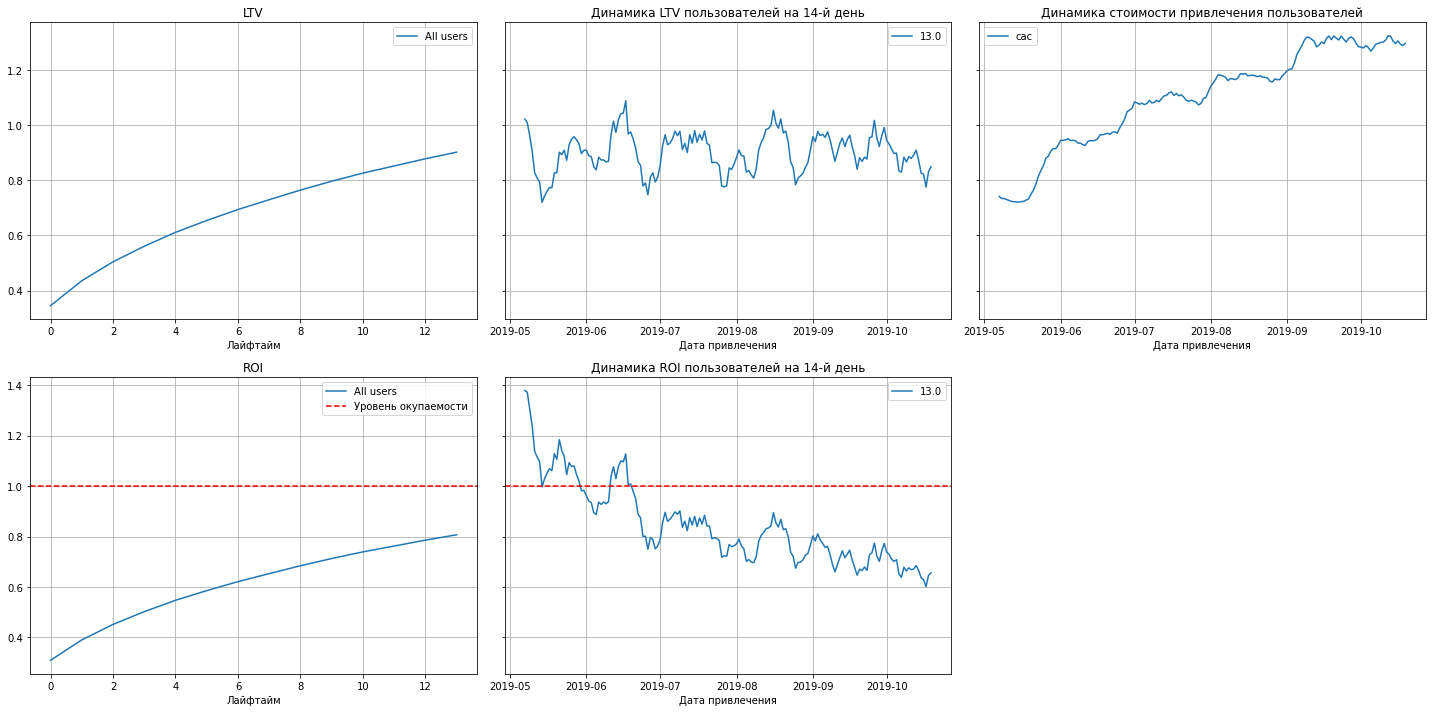

In [29]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 


По графикам можно сделать такие выводы:
- Реклама в среднем не окупается. ROI через две недели - около 80%.
- CAC растет. Значит, дело может быть в увеличении рекламного бюджета.
- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

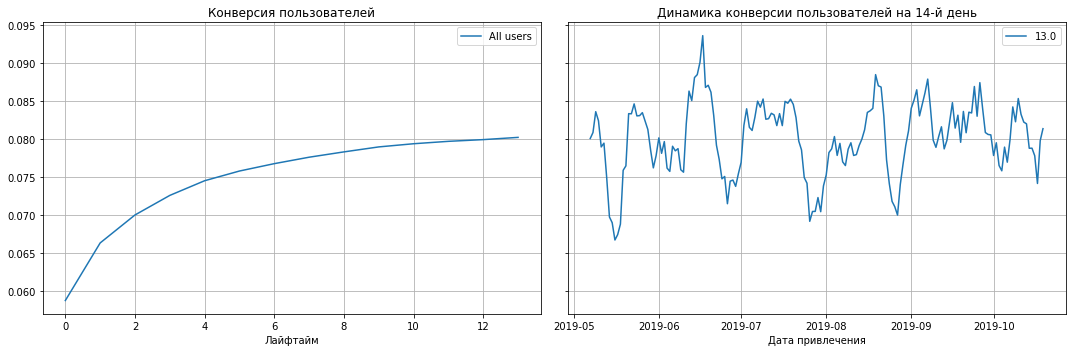

In [30]:
# смотрим общую конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

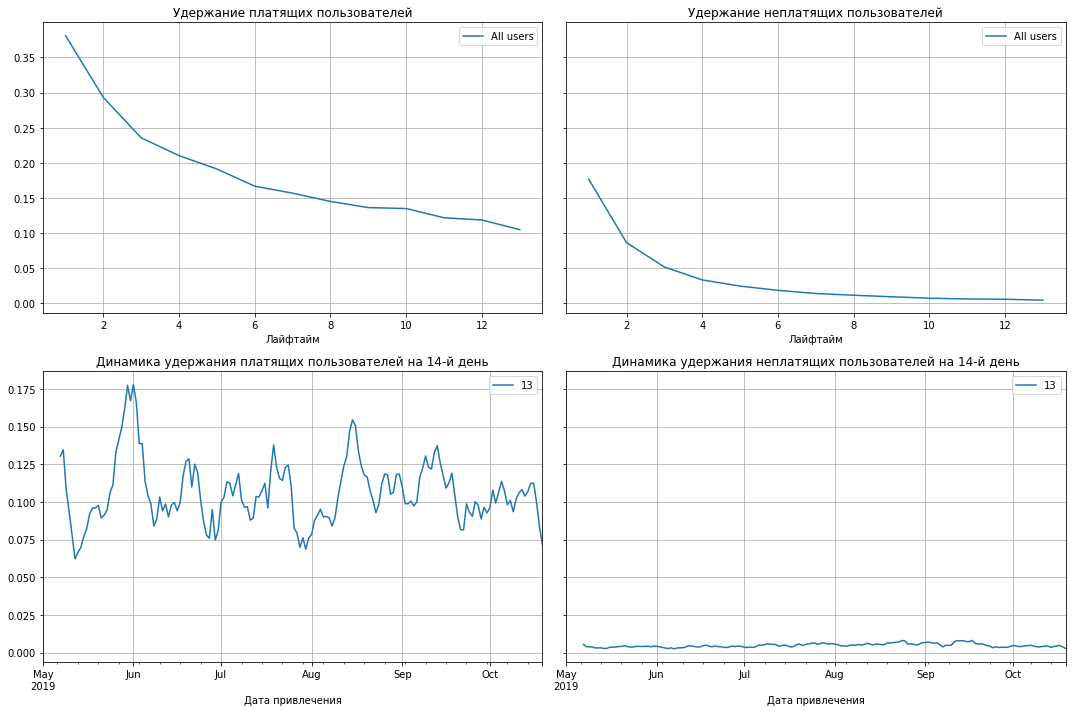

In [31]:
# смотрим  общее удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 


По общим графикам конверсии и удержания сложно делать какие-то выводы. Можно только сказать, что на 14 день средняя динамика конверсии и удержания достаточно стабильна и не сильно меняется за рассматириваемый период

#### Окупаемость рекламы в зависимости от различных факторов

##### Разбивка по устройствам

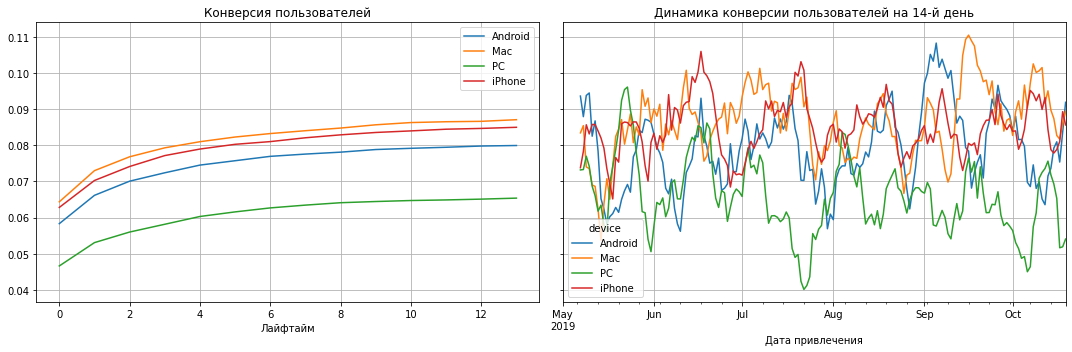

In [32]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']

)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Хуже всего конверсия на PC, лучше всего на Mac

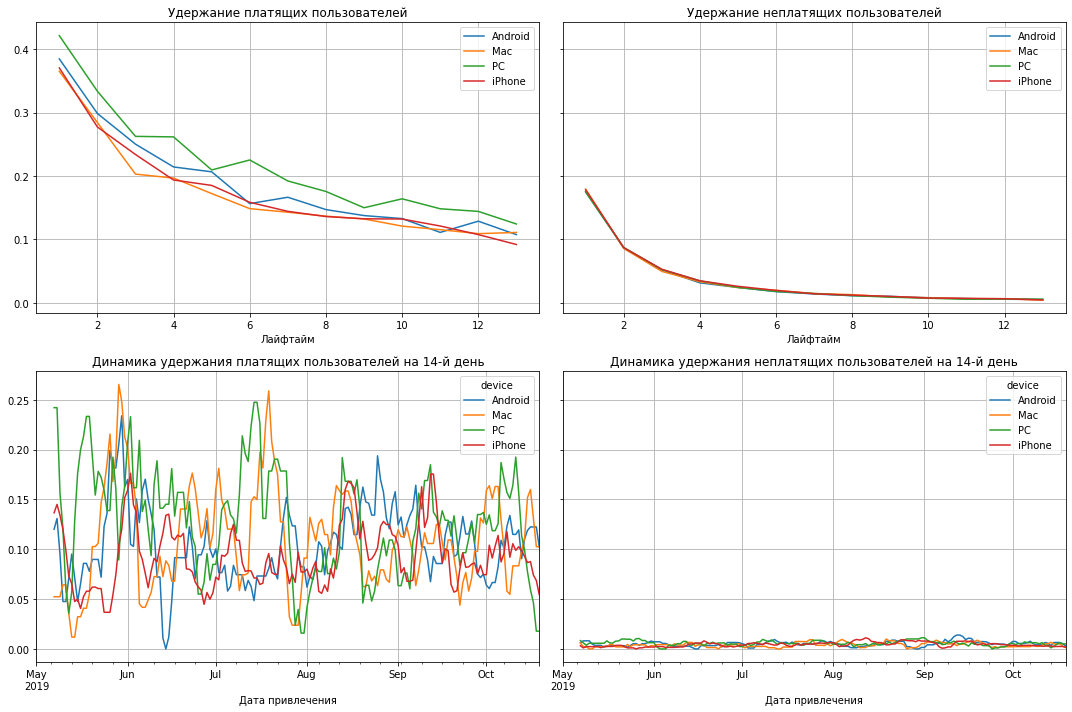

In [33]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 


Несмотря на плохую конверсию, удержание же лучше всего на PC. Остальные устройства не сильно отличаются.

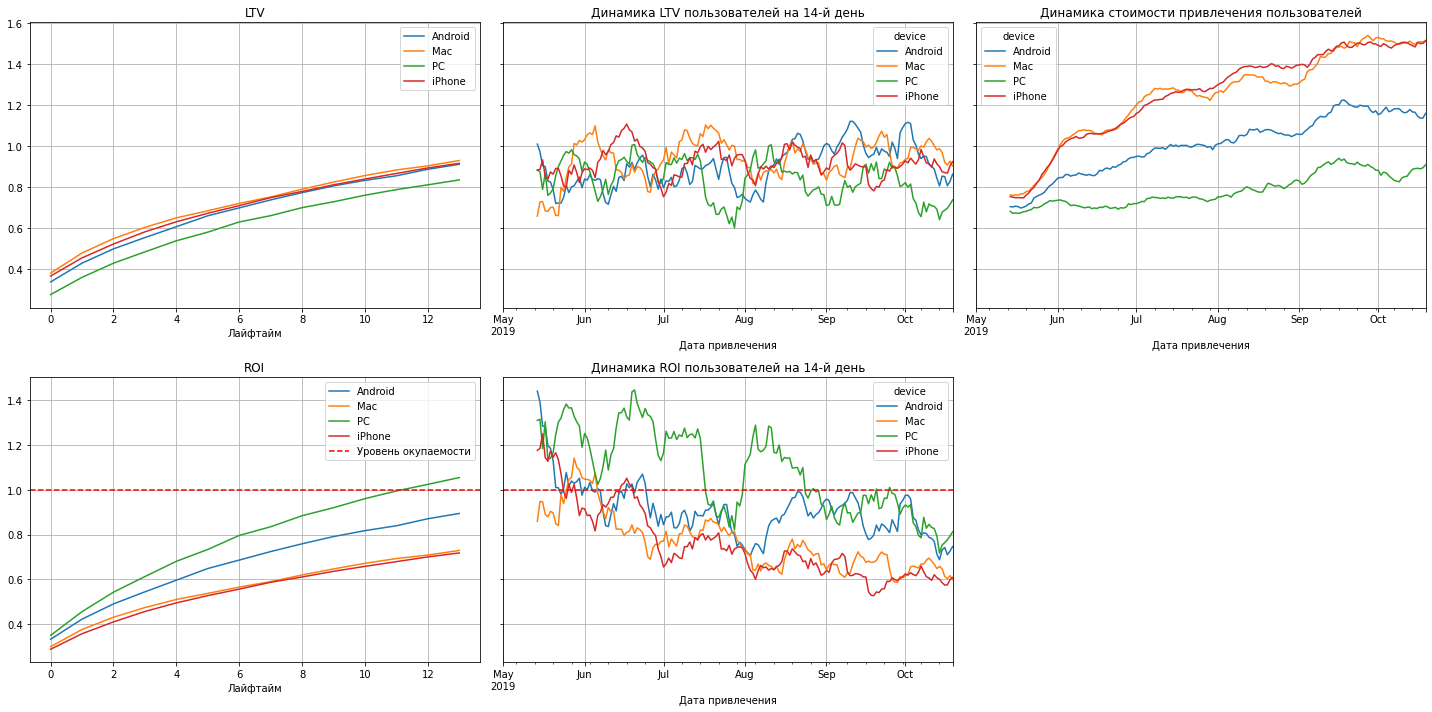

In [34]:
# смотрим окупаемость с разбивкой по устройствам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

LTV практически не зависит от устройства.  
При плохой конверсии быстрее всего окупается реклама на PC (в среднем уже через неделю) из-за самой низкой стоимости привлечения пользователей и относительно высокого удержания. Реклама на Mac, iPhone и Android за две недели не окупается. CAC растет вне зависимости от устройства. Динамика ROI на 14-й день по всем устройствам снижается, в соответствии с увеличением стоимости привлечения пользователей.

##### Разбивка по источникам

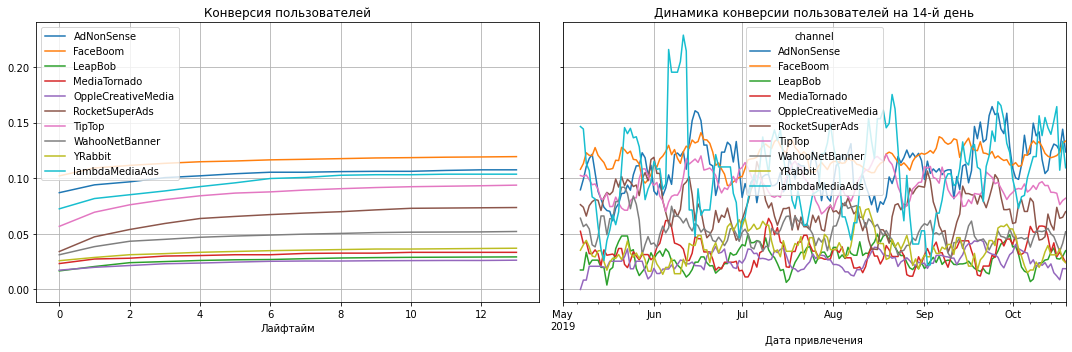

In [35]:
# смотрим конверсию с разбивкой по источникам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия лучше всего у FaceBoom, дальше идут AdNonSense и lambdaMediaAds

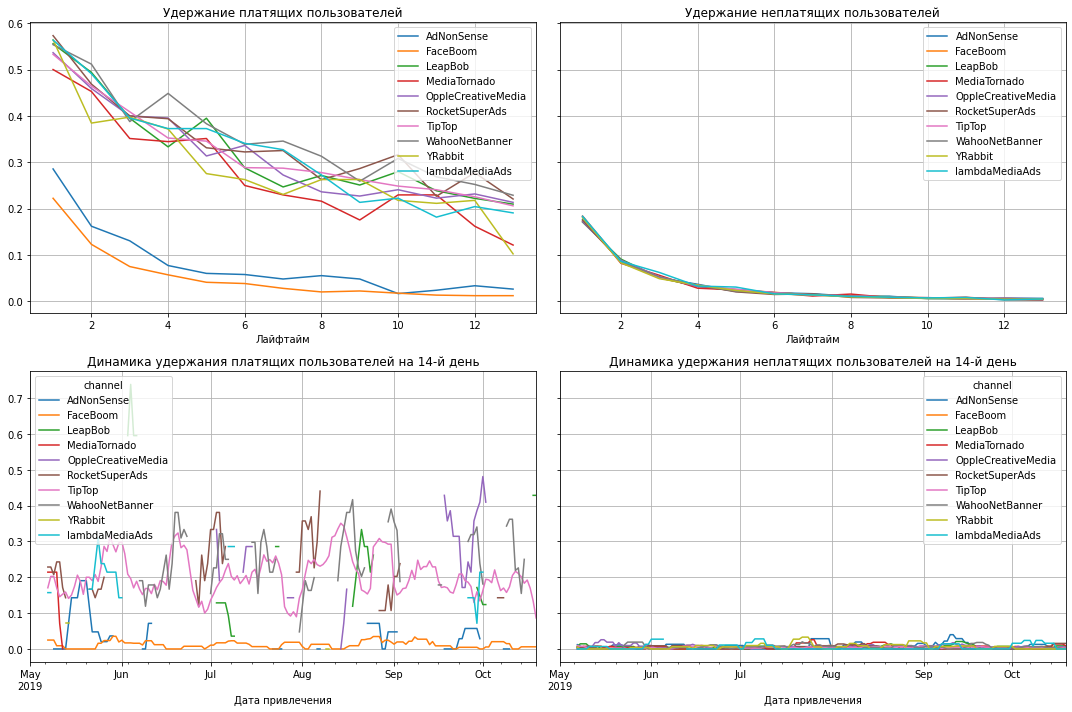

In [36]:
# смотрим удержание с разбивкой по источникам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

При неплохой конверсии удержание платящих пользователей из FaceBoom и AdNonSense хуже чем даже удержание органических пользователей. Все остальные источники показывают более высокое удержание.

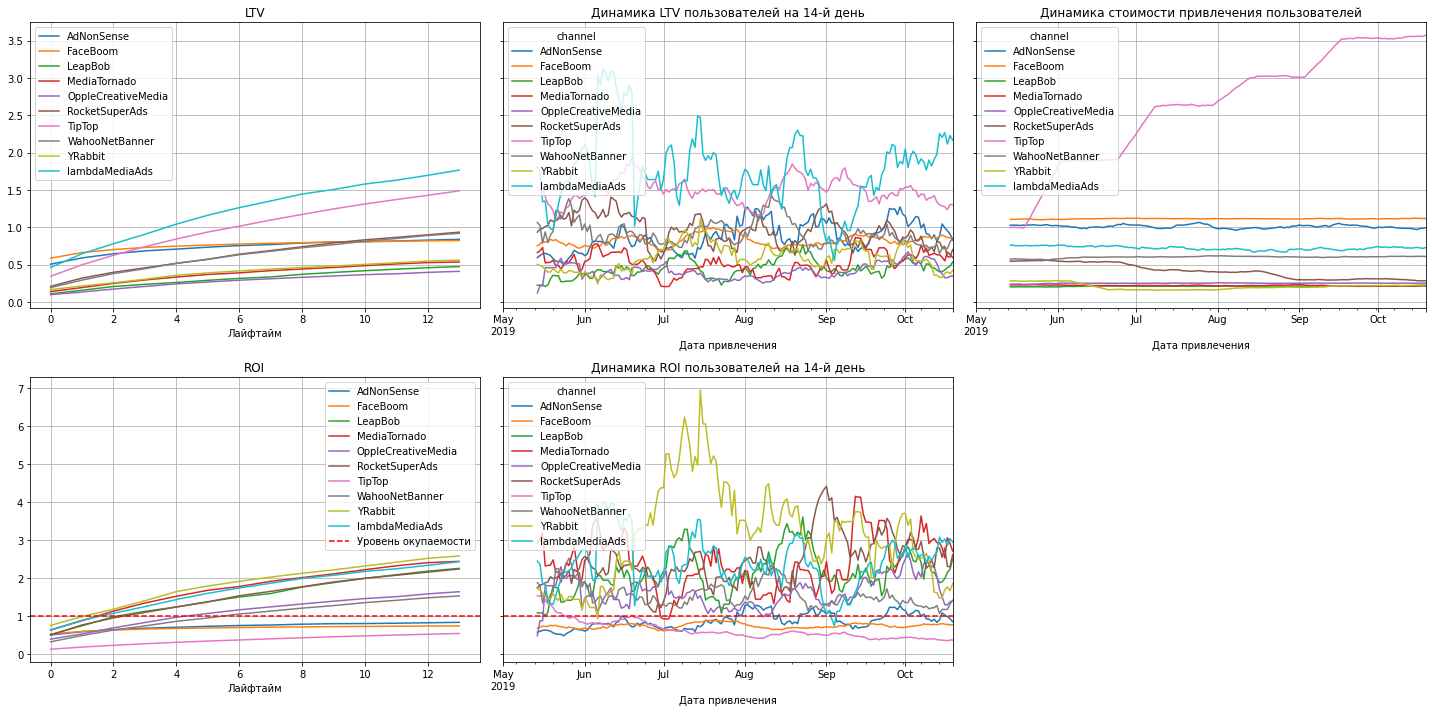

In [37]:
# смотрим окупаемость с разбивкой по источникам привлечения

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

График динамики САС показывает, что в большинстве источников стоимость привлечения плюс минус стабильна, но сильно растет TipTop. Возможно из-за этого реклама из этого источника не окупается. Так же за поставленный срок не окупается реклама AdNonSense и FaceBoom. Судя по динамике ROI эти два источника за рассматриваемый период практически никогда не окупались, поэтому логично будет перестать закупать там рекламу. Рекламу из TipTop возможно стоит сократить или так же перестать закупать. Быстрее всего окупается реклама через YRabbit. А так же у этого источника есть большой пик ROI в середине июля.

##### Разбивка по регионам

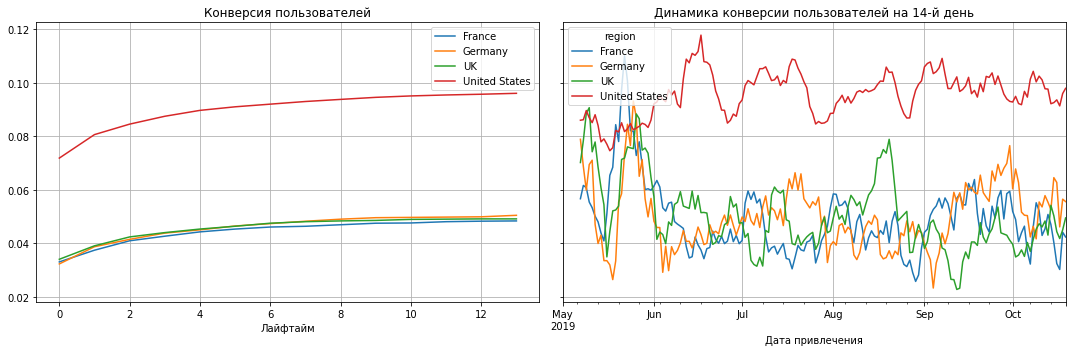

In [38]:
# смотрим конверсию с разбивкой по регионам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия выше всего в США. В других регионах она примерно одинаковая.

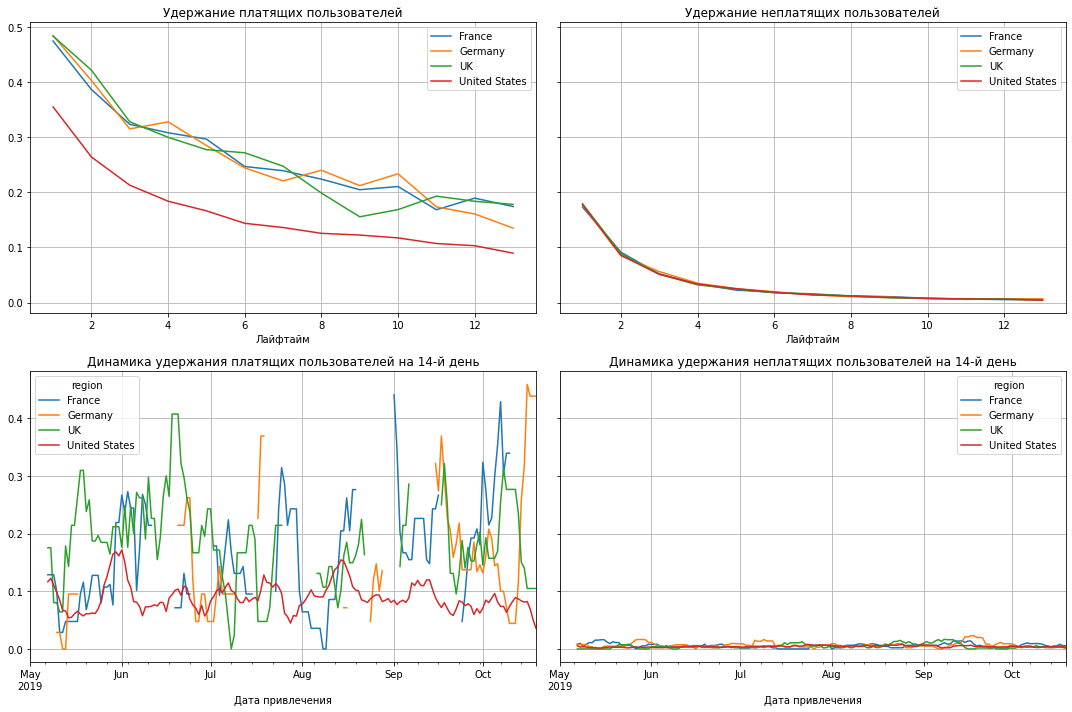

In [39]:
# смотрим удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей ниже всего тоже в US. Остальные страны в среднем выше.

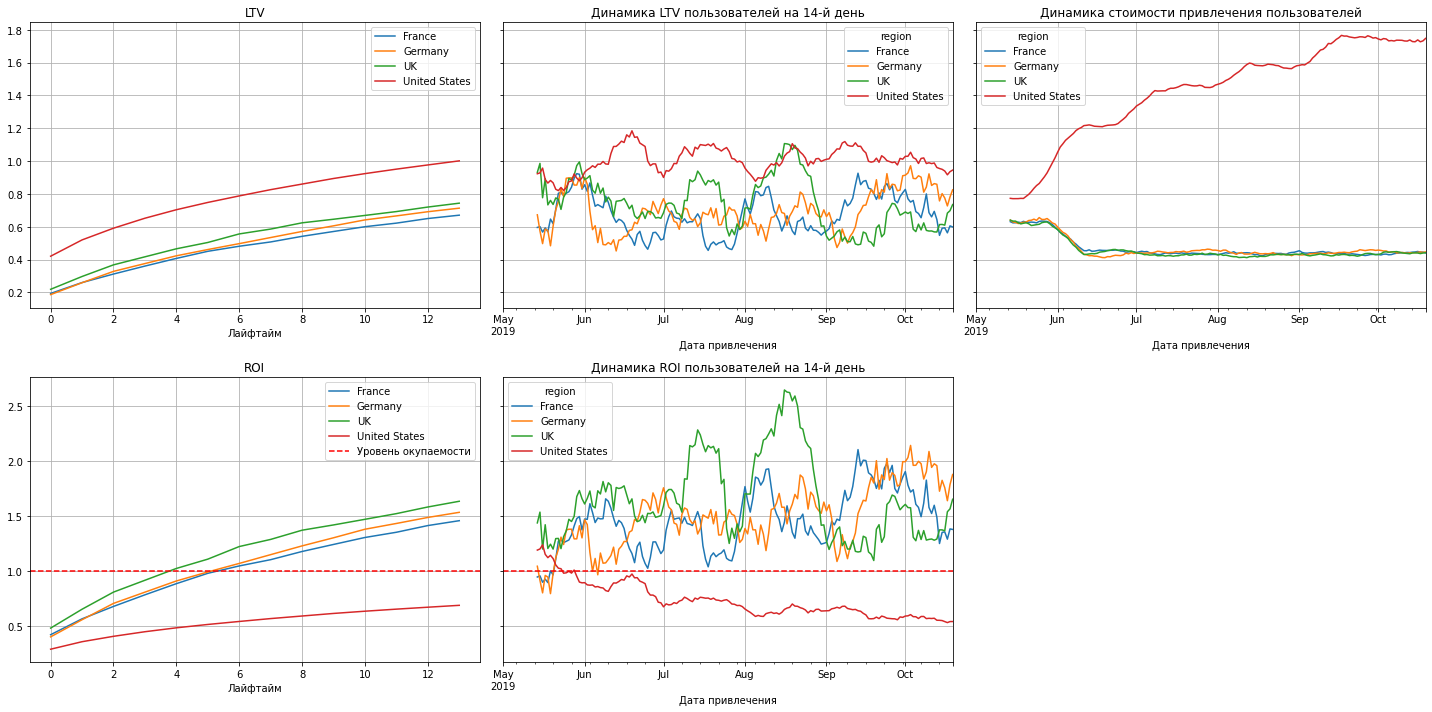

In [40]:
# смотрим окупаемость с разбивкой по регионам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

LTV выше всего у US. За время наблюдения CAC в US значительно вырос, в отличии от других регионов где этот показатель оставался более стабильным.  
С конца июня реклама в US перестала окупаться через две недели и срок окупаемости продолжает увеличиваться. Возможно влияет увеличение стоимости привлечения из источника TipTop. Проверим эту догадку.

##### Исключаем источник с растущей САС

In [41]:
profiles_wo_tiptop = profiles.query('channel != "TipTop"') # исключим этот канал привлечения

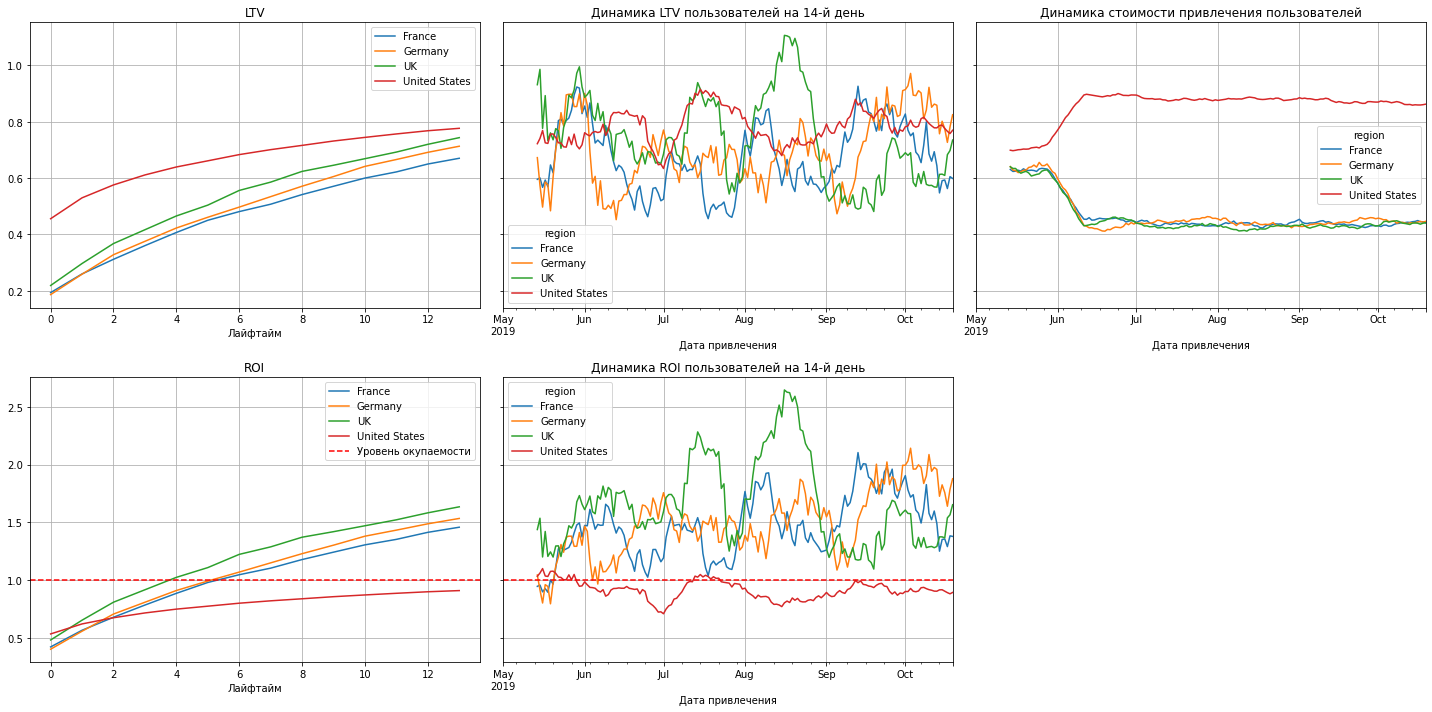

In [42]:
# смотрим как это повлияло на окупаемость с разбивкой по регионам.

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_tiptop, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Стоимость привлечения в US все еще растет до середины июля, но затем стабилизируется. Во всех регионах, кроме US реклама окупается уже начиная с 6 дня. По динамике ROI видно, что срок окупаемости больше не увеличивается, но этого улучшения не хватило США чтобы перейти уровень окупаемости за две недели. 

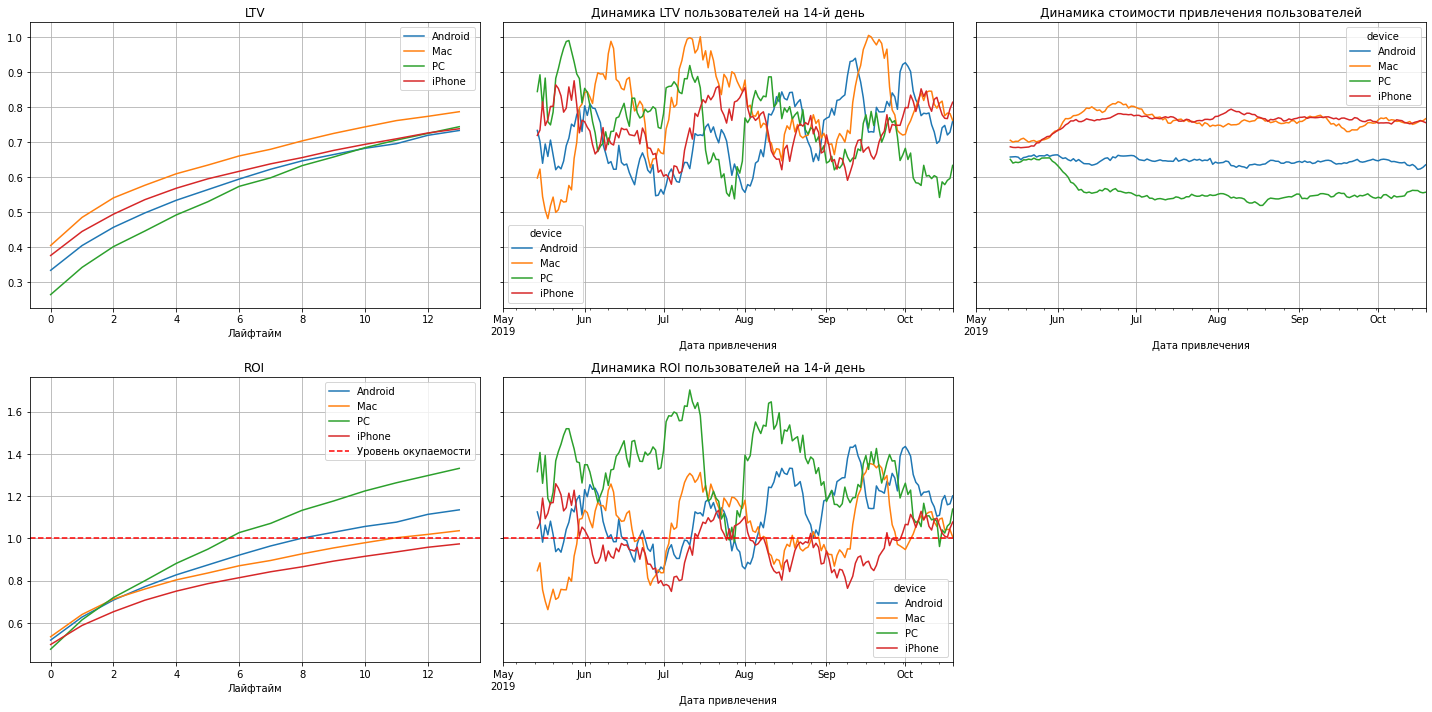

In [43]:
# смотрим как это повлияло на окупаемость с разбивкой по девайсам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_tiptop, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Реклама на Iphone и Mac все еще хуже окупается, чем на Android и ПК, но теперь это происходит гораздо быстрее на всех устройствах. И все же iPhone не хватило немного, чтобы окупаться через две недели.

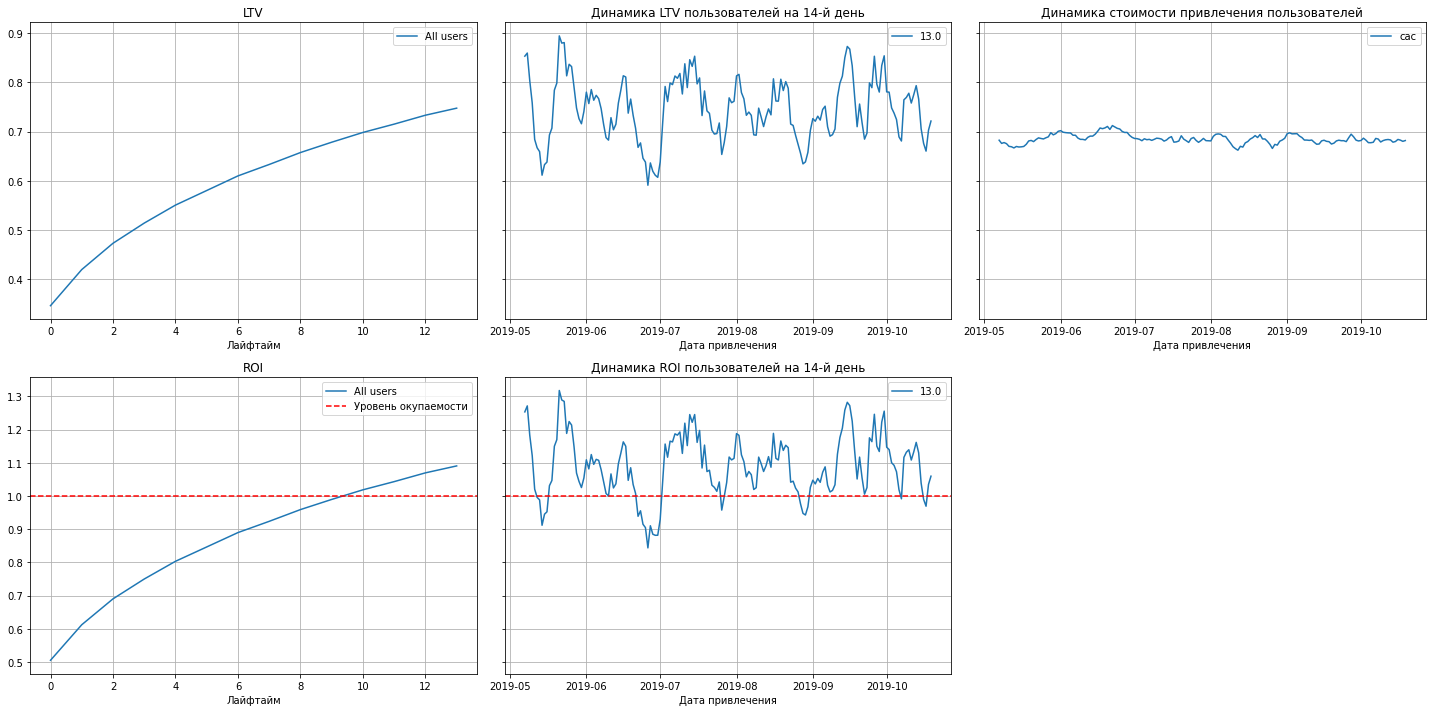

In [44]:
# смотрим как это повлияло на окупаемость в целом
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_tiptop, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Без рекламы в TipTop вся реклама в среднем окупается после 9 дня, СAC в среднем стабилизировался.

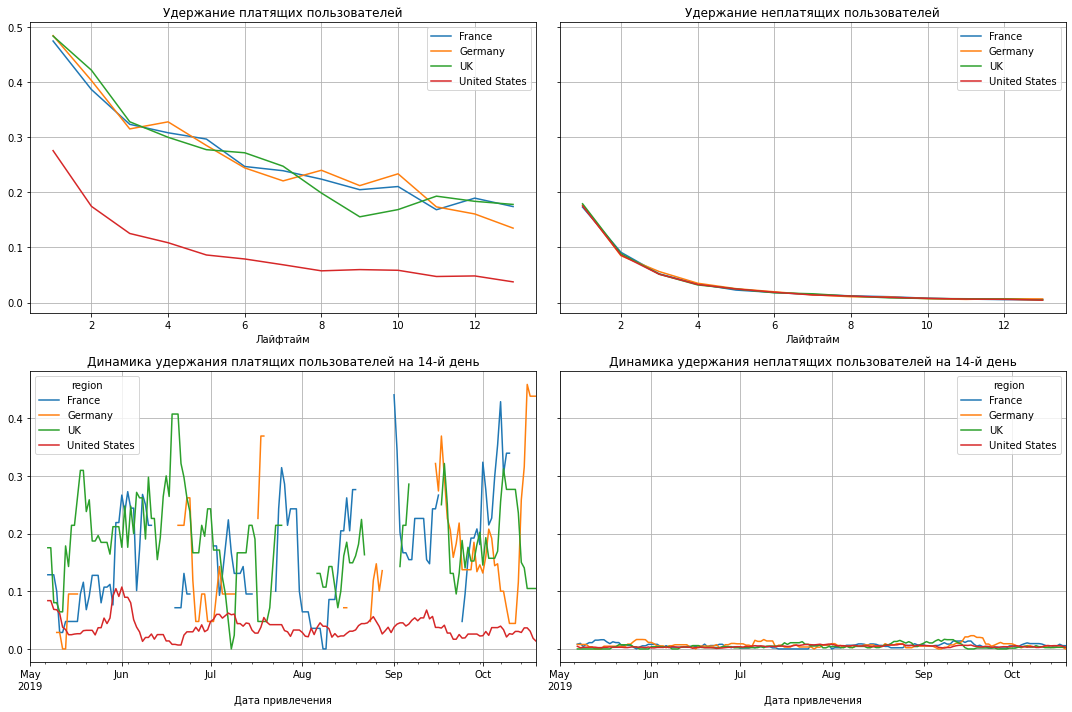

In [45]:
# смотрим удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_wo_tiptop, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание же без источника TipTop не увеличилось в US. Уберем так же с графика каналы с низким удержанием, чтобы проверить эту теорию.

##### Исключаем каналы с низким удержанием

In [46]:
# исключим эти каналы привлечения
profiles_wo_lowret_ch = profiles_wo_tiptop.query('channel != "FaceBoom" & channel != "AdNonSense"') 

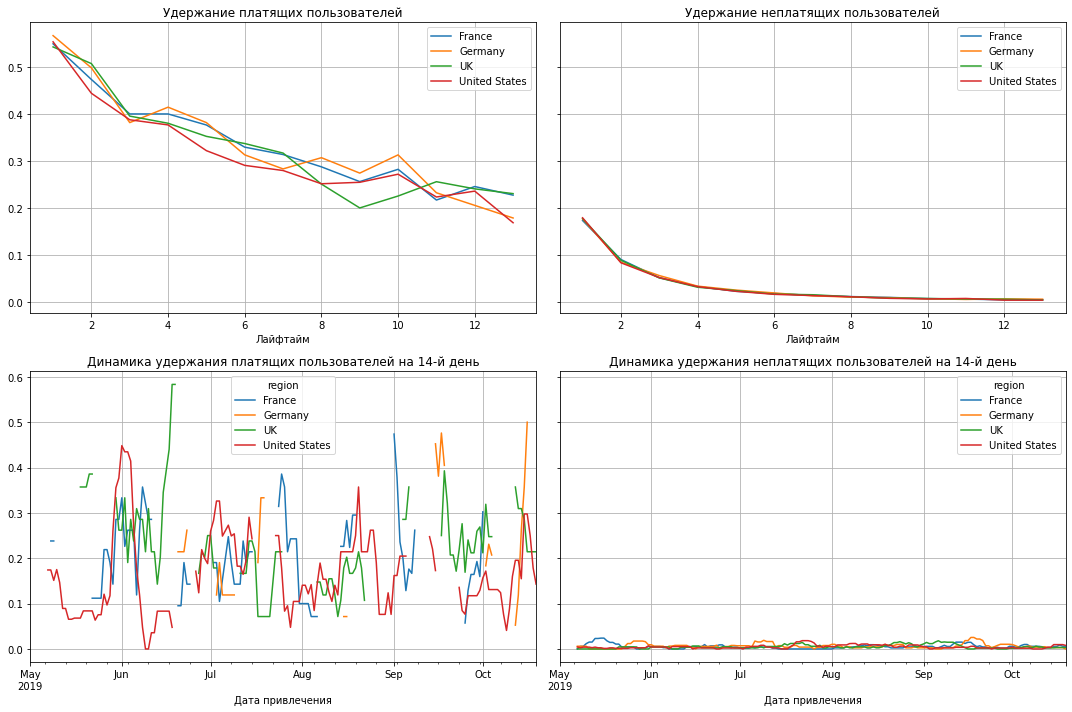

In [47]:
# смотрим удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_wo_lowret_ch, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание в US сравнялось с другими странами.

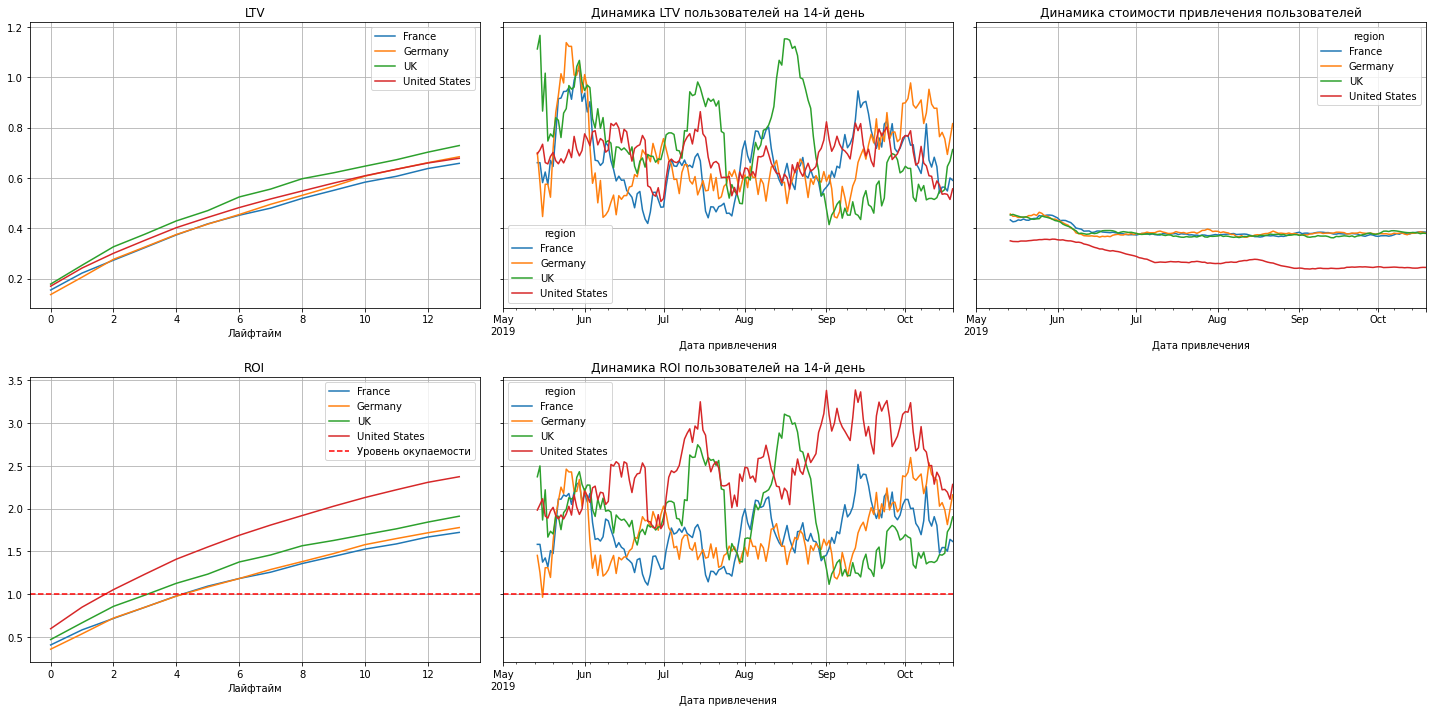

In [48]:
# смотрим как это повлияло на окупаемость с разбивкой по регионам.

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_lowret_ch, orders, observation_date, horizon_days, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Убрав еще два источника привлечения рекламы мы добились во всех странах окупаемости уже на 4-й день. Стоимость привлечения пользователя в US значительно снизилась.
В целом больше всего на окупаемость повлиял рост стоимости привлечения пользователей и удержание. Даже высокой конверсии не удалось спасти ситуацию.

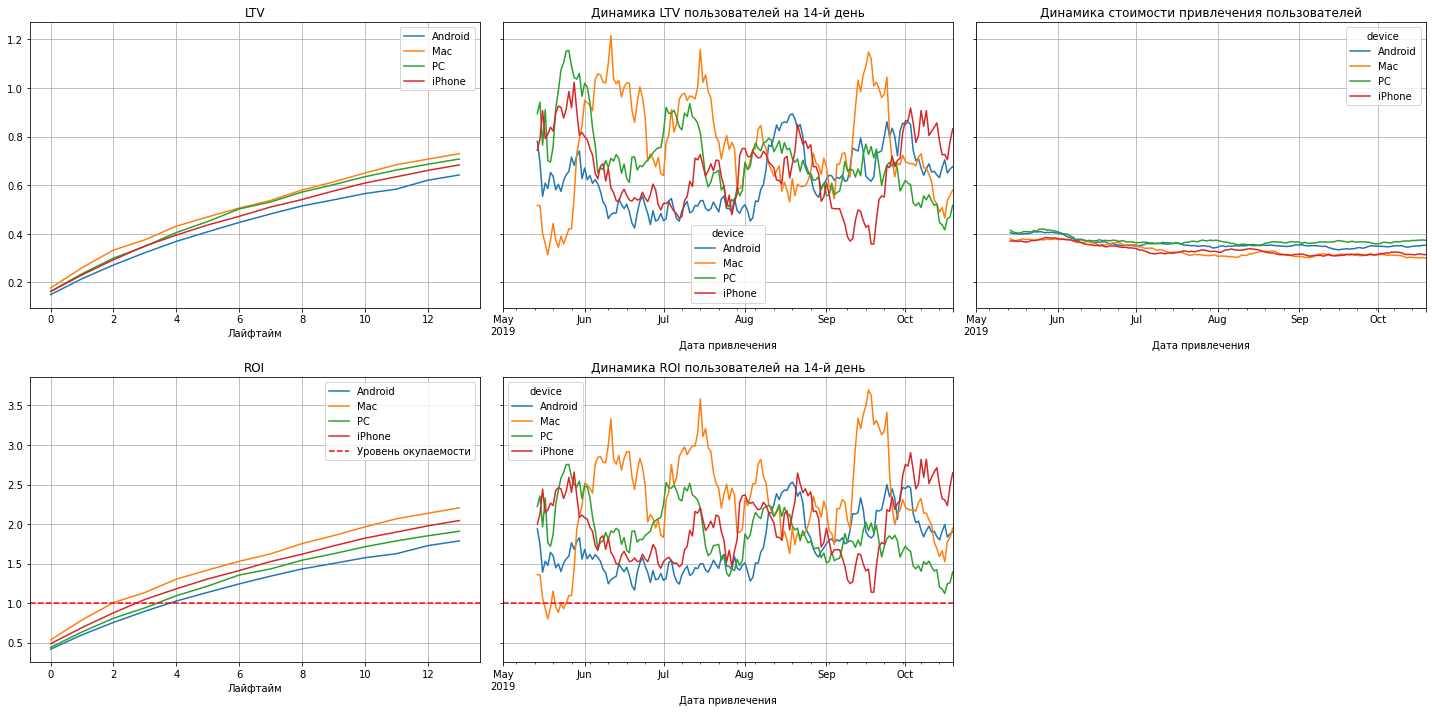

In [49]:
# смотрим как это повлияло на окупаемость с разбивкой по девайсам

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_wo_lowret_ch, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Скорость окупаемости выросла на всех девайсах. Больше всего устранение источников с низким удержанием повлияло на ROI на iPhone и Mac. 

### Выводы

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача была разобраться в причинах, и помочь компании выйти в плюс.  
Мы рассмотрели три датасета. Лог сервера с информацией о посещениях сайта, информацию о заказах и информацию о расходах на рекламу.
Проверили данные на пропуски и дубликаты. Убедились, что типы данных во всех колонках соответствуют сохранённым в них значениям и подкорректировали несоответствия.  
Изучили датасеты и выяснили:
- За какой период рассматриваемые данные:   
Минимальная дата привлечения покупателей: 2019-05-01   
Максимальная дата привлечения покупателей: 2019-10-27   
- Выше всего доля платящих пользователей в США
- Выше всего доля платящих на устройствах Mac. Доли платящих с разных устройств различаются меньше чем доли платящих в разных странах
- Больше всего доля плательщиков из источника FaceBoom, затем AdNonSense и lambdaMediaAds
- Всего на рекламу было потрачено 105497.30
- Больше всего потрачено на привлечение пользователей через канал "TipTop", а меньше всего на "YRabbit"
- Расходы на рекламу в TipTop и FaceBoom растут
- Самое дорогое привлечение  с большим отрывом оказалось у TipTop  

Для начала оценили общую ситуацию — посмотрели на окупаемость рекламы. Рассчитали и визуализировали LTV и ROI
По графикам можно сделать такие выводы:
- Реклама в среднем не окупается за две недели. ROI около 80%.
- CAC растет. Значит, дело может быть в увеличении рекламного бюджета.
- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.  

По общим графикам конверсии и удержания можно сказать, что средняя динамика конверсии и удержания достаточно стабильна и не сильно меняется за рассматриваемый период.

Далее мы рассмотрели ситуацию с разбивкой по различным факторам. 
  
По устройствам:  
- Хуже всего конверсия на PC, лучше всего на Mac
- Несмотря на плохую конверсию, удержание же лучше всего на PC. Остальные устройства не сильно отличаются.
- LTV практически не зависит от устройства.  
- Быстрее всего окупается реклама на PC (в среднем уже через неделю) из-за самой низкой стоимости привлечения пользователей и относительно высокого удержания. 
- Реклама на Mac и iPhone за две недели не окупается. 
- CAC растет вне зависимости от устройства. 
- Динамика ROI на 14-й день по всем устройствам снижается, в соответствии с увеличением стоимости привлечения пользователей.   
  
По каналам привлечения:  
- Конверсия лучше всего у FaceBoom, дальше идут AdNonSense и lambdaMediaAds
- При неплохой конверсии удержание платящих пользователей из FaceBoom и AdNonSense хуже, чем даже удержание органических пользователей. Все остальные источники показывают более высокое удержание.
- График динамики САС показывает, что в большинстве источников стоимость привлечения плюс-минус стабильна, но сильно растет TipTop. Возможно из-за этого реклама из этого источника не окупается. 
- За поставленный срок не окупается реклама AdNonSense и FaceBoom. Судя по динамике ROI эти два источника за рассматриваемый период практически никогда не окупались. 
- Быстрее всего окупается реклама через YRabbit. А так же у этого источника есть большой пик ROI в середине июля.  

По регионам:

- Конверсия выше всего в США. В других регионах она примерно одинаковая.
- Удержание пользователей ниже всего тоже в US. Остальные страны в среднем выше.
- LTV выше всего у US. За время наблюдения CAC в US значительно вырос, в отличие от других регионов, где этот показатель оставался более стабильным.  
- С конца июня реклама в US перестала окупаться через две недели и срок окупаемости продолжает увеличиваться. Возможно влияет увеличение стоимости привлечения из источника TipTop. (единственный источник где САС растет)

Исключили данные из TipTop, чтобы проверить как это повлияло на разбивку данных по другим факторам:

- Стоимость привлечения в US все еще растет до середины июля, но затем стабилизируется. Во всех регионах, кроме US реклама окупается уже начиная с 6 дня. По динамике ROI видно, что срок окупаемости больше не увеличивается, но этого улучшения не хватило США, чтобы перейти уровень окупаемости за две недели.
- Реклама на Iphone и Mac все еще хуже окупается, чем на Android и ПК, но теперь это происходит гораздо быстрее на всех устройствах. И все же iPhone не хватило немного, чтобы окупаться через две недели.
- Вся реклама в среднем окупается после 4 дня, CAC в среднем растет до июня, а дальше стабилизируется.
- Удержание же не увеличилось в US.

Убрали так же с графика каналы с низким удержанием, чтобы проверить как влияет этот фактор:

- Удержание в US сравнялось с другими странами.
- Во всех странах окупаемость происходит уже на 4-й день. Стоимость привлечения пользователя в US значительно снизилась.
- Скорость окупаемости выросла на всех девайсах. Больше всего устранение источников с низким удержанием повлияло на ROI на iPhone и Mac. 

Главная ошибка заключалась в том, что был сделан акцент на неправильные каналы привлечения. За счет роста цены привлечения пользователя через канал TipTop, реклама через этот канал стала убыточной, попутно сделав убыточным все рекламное продвижение. Больше всего плательщиков принесли FaceBoom и AdNonSense, у них большая конвертация. Но отдел маркетинга видимо не обратил внимание на плохое удержание пользователей пришедших из этих источников. Следует проанализировать, почему так происходит и исправить это (Чем реклама на этих площадках отличается от других?). Если же исправить ситуацию не представляется возможным, то сократить закупку рекламы или вовсе отказаться от этих каналов в пользу более перспективных вроде YRabbit.